In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import cv2
import numpy as np
import os

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks
import tensorflow as tf
from keras.models import model_from_json
from keras.models import load_model

In [ ]:
#Video preprocessing. Сompressing and cropping them to the same size
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    frames = []
    frame_count = 0
    max_frames = 80

    while(cap.isOpened() and frame_count < max_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (100, 56))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        frames.append(frame)

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

    return frames

In [ ]:
data = []
emotions = []

for subdir, dirs, files in os.walk('/content/drive/MyDrive/Dataset/dataset'):
    for file in files:
        if file.endswith('.mp4') or file.endswith('.avi'):
            video_path = os.path.join(subdir, file)

            data.append(process_video(video_path))
            emotion_code = file.split("-")[2]
            emotions.append(int(emotion_code[1])-1)

You can download pre-processed videos from google drive<br>
Data: https://drive.google.com/file/d/1mqP1ZKqd-hIrzilWadbkaLkxKKIqiL_5/view?usp=sharing<br>
Emotions: https://drive.google.com/file/d/1DClF0sJPcpR9Szrh2OJ9nlClw2iQDS1y/view?usp=sharing

In [3]:
data = np.load('/content/drive/MyDrive/array.npy')
emotions = np.load('/content/drive/MyDrive/emot.npy')

In [4]:
data = np.array(data)

In [5]:
data = data.reshape(data.shape[0], 80, 5600)

In [6]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(data, emotions, test_size=0.2, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

y_train_class = tf.keras.utils.to_categorical(y_train, num_classes=8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, num_classes=8, dtype = 'int8')

In [7]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 5600,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
print(model.summary())

batch_size = 32

checkpoint_path = 'best_weights.hdf5'

mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=40, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 5598, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 2799, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 2797, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 1398, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 1396, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 698, 128)       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 26s 362ms/step - loss: 2.0097 - categorical_accuracy: 0.2055 - val_loss: 1.9799 - val_categorical_accuracy: 0.2075 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - 26s 361ms/step - loss: 1.9174 - categorical_accuracy: 0.2489 - val_loss: 1.8624 - val_categorical_accuracy: 0.3275 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - 26s 362ms/step - loss: 1.8228 - categorical_accuracy: 0.3010 - val_loss: 1.8059 - val_categorical_accuracy: 0.3850 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - 26s 360ms/step - loss: 1.6886 - categorical_accuracy: 0.3788 - val_loss: 1.8526 - val_categorical_accuracy: 0.3625 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - 26s 359ms/step - loss: 1.6737 - categorical_accuracy: 0.4057 - val_loss: 1.7958 - val_categorical_accuracy: 0.3725 - lr: 0.0010
Epoch 7/40
72/72 [==============================] - 26s 360ms/step - loss: 1.5749 - categorical_accuracy: 0.431

In [16]:
model_json = model.to_json()
saved_model_path = 'model.json'
saved_weights_path = 'model_weights.h5'

with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


In [ ]:
saved_model_path = 'model.json'
saved_weights_path = 'model_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_accuracy'])

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

In [12]:
x_test = np.asarray(x_test).astype('float32')

y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [13]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

6/6 - 1s - loss: 0.5254 - categorical_accuracy: 0.8523 - 875ms/epoch - 146ms/step


6/6 [==============================] - 1s 119ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

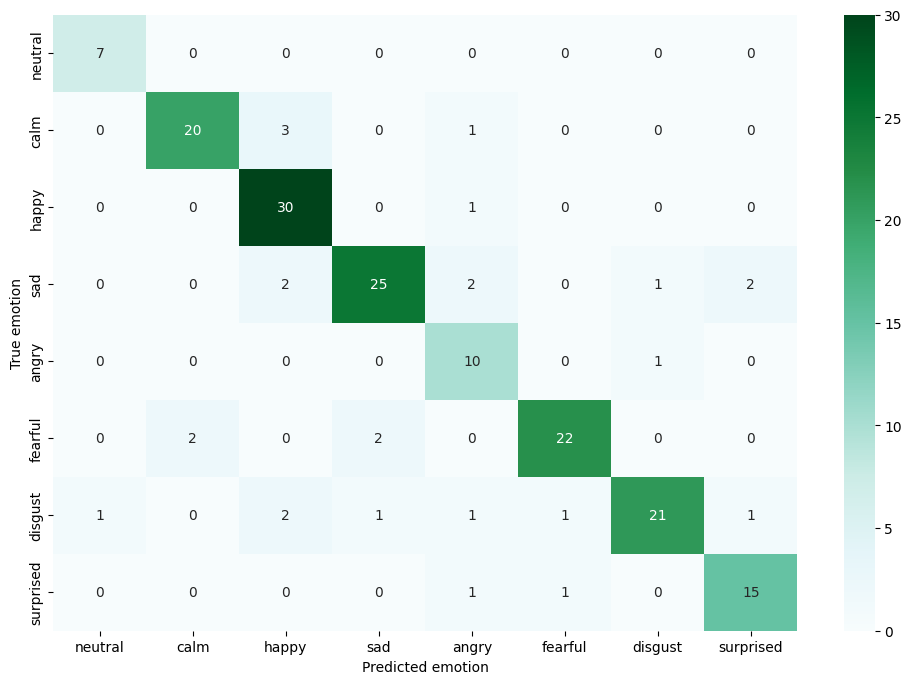

In [14]:
y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [15]:
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

neutral : 1.0000
calm : 0.8333
happy : 0.9677
sad : 0.7812
angry : 0.9091
fearful : 0.8462
disgust : 0.7500
surprised : 0.8824
